In [56]:
from pandas_datareader import data
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
# Establishing Dates
start = "2016-06-01"
end = datetime.today().strftime('%Y-%m-%d')

# Establishing Assets
assets = ['VTWO', 'VUG', 'VTI', 'VXUS', 'VO']

#252 trading days in a year
N = 252

#1% risk free rate
rf =0.02

# Creating an empty dataframe
df_prices = pd.DataFrame()

# Getting the "Adj Close" data from Yahoo Finance by defining a function
# This function lists the price data as daily percent change 
# This function also drops the NA first row
def YahooData(dataframe, assets_list, start_date, end_date):
    for i in assets_list:
        dataframe[i] = data.DataReader(i, data_source = "yahoo", start=start_date, end=end_date)['Adj Close']
    return dataframe

# Running the function that we just made and saving the results to the DataFrame
df = YahooData(df_prices, assets, start, end)

# Calculating Log Return
df = np.log(df/df.shift(1))

# Dropping the first row because it's N/A
df = df.dropna()

# Viewing df head
df

,VTWO,VUG,VTI,VXUS,VO
Date,,,,,
2016-06-02,0.007199,0.003502,0.003339,0.001978,0.006090
2016-06-03,-0.006013,-0.002395,-0.002782,0.008963,-0.004564
2016-06-06,0.011032,0.002670,0.005187,0.007372,0.005443
2016-06-07,0.002660,0.000736,0.001938,0.008390,0.004937
2016-06-08,0.007831,0.003486,0.003497,0.003635,0.003331
...,...,...,...,...,...
2021-06-01,0.010917,-0.003476,0.000413,0.009440,0.003116
2021-06-02,0.001085,0.001111,0.001328,0.002235,-0.000341
2021-06-03,-0.008715,-0.009369,-0.004450,-0.007618,-0.004273


In [58]:
# Creating 10000 random simulations of each portfolio weight configuration
num_runs = 10000 # number of rows/iterations

# Creating a Matrix with 10000 rows, with each row representing a random portfolio:
    #first 3 columns are Mean Returns, Standard Deviation, and Sortino Ratio
    # remaining columns are each assets random weight within that random portfolio
result = np.zeros((num_runs,(len(assets)+5)))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
df = df.copy()

for i in range(num_runs):
    
    # randomized weights
    weights = np.array(np.random.random(len(assets))) 
    #Rebalance w/ constraints (SUM of all weights CANNOT BE > 1)
    weights = weights/np.sum(weights)
    
    # daily return of the portfolio based on a given set of weights
    df['portfolio_ret'] = df.iloc[:,0]*weights[0]+df.iloc[:,1]*weights[1]+df.iloc[:,2]*weights[2]
    
    # Calculating Mean
    E = df['portfolio_ret'].mean()
    # Annualizing Mean
    E_AN = E * N
    
    # Calculating Downside Standard Deviation
    mean = E * N -rf
    std_neg = df['portfolio_ret'][df['portfolio_ret']<0].std()*np.sqrt(N)
    
    
    # Calculating Upside Standard Deviation
    std_pos = df['portfolio_ret'][df['portfolio_ret']>=0].std()*np.sqrt(N)
    
    # Calculating Volatility Skewness
    VS = std_pos/std_neg
    
    # Sortino
    Sortino = mean/std_neg
   
    # Populating the 'result' array with the required values: Mean, SD, Sharpe followed by the weights                   
    result[i,0] = E_AN
    result[i,1] = std_neg
    result[i,2] = std_pos
    result[i,3] = VS
    result[i,4] = Sortino
    
    for j in range(len(assets)):
        result[i,j+5]= weights[j]

In [60]:
# Converting 'result' into a DataFrame

columns = ['Mean','Downside SD', 'Upside SD', 'Volatility Skewness', 'Sortino'] + assets

result = pd.DataFrame(result,columns=columns)
result

,Mean,Downside SD,Upside SD,Volatility Skewness,Sortino,VTWO,VUG,VTI,VXUS,VO
0,0.126808,0.148195,0.104337,0.704051,0.720724,0.339438,0.216930,0.206200,0.134607,0.102825
1,0.111081,0.134539,0.095513,0.709931,0.676988,0.328420,0.073899,0.291568,0.288335,0.017779
2,0.074000,0.079552,0.056286,0.707543,0.678808,0.128545,0.269601,0.013266,0.245055,0.343533
3,0.108742,0.113669,0.081933,0.720802,0.780702,0.079860,0.380704,0.141251,0.047098,0.351087
4,0.061594,0.072968,0.051331,0.703470,0.570036,0.212521,0.127809,0.028005,0.299176,0.332489
...,...,...,...,...,...,...,...,...,...,...
9995,0.108247,0.123902,0.087260,0.704269,0.712231,0.224774,0.199310,0.220366,0.181671,0.173879
9996,0.091441,0.110351,0.078252,0.709124,0.647403,0.245114,0.049557,0.277499,0.108669,0.319161
9997,0.127092,0.149534,0.105444,0.705149,0.716171,0.320738,0.167774,0.285042,0.020515,0.205932
9998,0.090583,0.105519,0.075197,0.712637,0.668914,0.138387,0.049464,0.373158,0.287333,0.151658


In [61]:
Max_Sortino = result.iloc[result['Sortino'].idxmax()]
Max_Sortino

Mean                   0.177130
Downside SD            0.180570
Upside SD              0.131632
Volatility Skewness    0.728981
Sortino                0.870188
VTWO                   0.077825
VUG                    0.708545
VTI                    0.172651
VXUS                   0.006059
VO                     0.034920
Name: 2840, dtype: float64

In [62]:
Min_DSD = result.iloc[result['Downside SD'].idxmin()]
Min_DSD

Mean                   0.007619
Downside SD            0.009465
Upside SD              0.006736
Volatility Skewness    0.711601
Sortino               -1.308015
VTWO                   0.027285
VUG                    0.003614
VTI                    0.017258
VXUS                   0.371646
VO                     0.580197
Name: 4866, dtype: float64

In [63]:
min_skew = result.iloc[result['Volatility Skewness'].idxmin()]
min_skew

Mean                   0.087795
Downside SD            0.100898
Upside SD              0.070262
Volatility Skewness    0.696365
Sortino                0.671913
VTWO                   0.261224
VUG                    0.247571
VTI                    0.000315
VXUS                   0.200263
VO                     0.290628
Name: 3513, dtype: float64

In [64]:
max_skew = result.iloc[result['Volatility Skewness'].idxmax()]
max_skew

Mean                   0.125017
Downside SD            0.122386
Upside SD              0.090690
Volatility Skewness    0.741013
Sortino                0.858079
VTWO                   0.005698
VUG                    0.633265
VTI                    0.007470
VXUS                   0.338306
VO                     0.015260
Name: 7372, dtype: float64

In [65]:
max_mean = result.iloc[result['Mean'].idxmax()]
max_mean

Mean                   0.177130
Downside SD            0.180570
Upside SD              0.131632
Volatility Skewness    0.728981
Sortino                0.870188
VTWO                   0.077825
VUG                    0.708545
VTI                    0.172651
VXUS                   0.006059
VO                     0.034920
Name: 2840, dtype: float64

In [66]:
max_UP = result.iloc[result['Upside SD'].idxmax()]
max_UP

Mean                   0.153705
Downside SD            0.196777
Upside SD              0.139936
Volatility Skewness    0.711141
Sortino                0.679473
VTWO                   0.670587
VUG                    0.070275
VTI                    0.237768
VXUS                   0.016402
VO                     0.004969
Name: 3352, dtype: float64

In [67]:
min_skew = result.iloc[result['Volatility Skewness'].idxmin()]
min_skew

Mean                   0.087795
Downside SD            0.100898
Upside SD              0.070262
Volatility Skewness    0.696365
Sortino                0.671913
VTWO                   0.261224
VUG                    0.247571
VTI                    0.000315
VXUS                   0.200263
VO                     0.290628
Name: 3513, dtype: float64

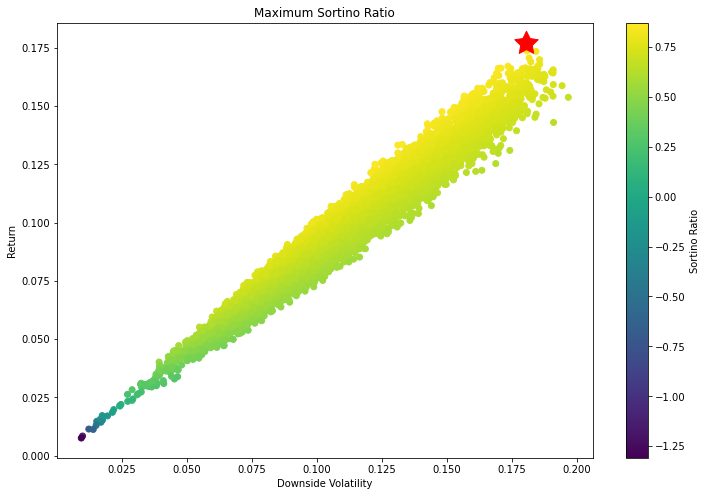

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(x=result['Downside SD'],y=result['Mean'],c=result['Sortino'],cmap='viridis')
plt.colorbar(label='Sortino Ratio')
plt.xlabel('Downside Volatility')
plt.ylabel('Return')

plt.title('Maximum Sortino Ratio')
#Plot a red star to highlight position of the portfolio with highest Sortino Ratio
plt.scatter(Max_Sortino[1],Max_Sortino[0],marker=(5,1,0),color='r',s=600)

plt.show()